In [54]:
import pandas as pd
from datetime import datetime
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sps
%matplotlib inline

## Задача 2

In [166]:
data = pd.read_excel('hw12t2.xls', header=None)
data.head()

,0
0,0.012698
1,0.022681
2,-0.051218
3,-0.022244
4,-0.054943


Проверим, что у нас нет пропущенных значений

In [141]:
data.isnull().values.any()

False

Посмотрим на временной ряд

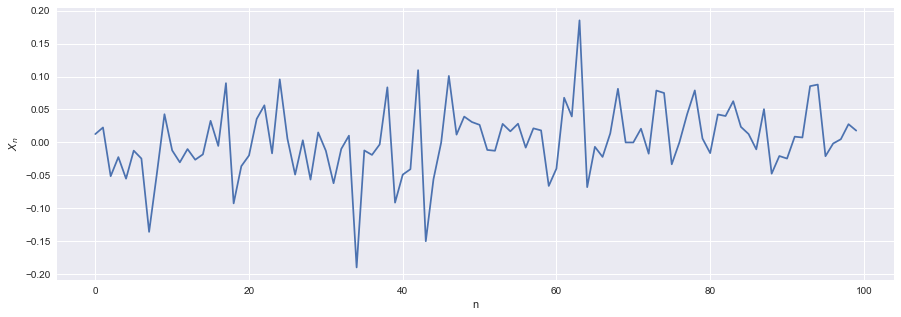

In [142]:
data = np.array(data)[:,0]

plt.figure(figsize=(15, 5))
plt.plot(data)
plt.xlabel('n')
plt.ylabel('$X_n$')
plt.show()


Разобьем на обучение и тест

In [144]:
train = data[:-20]
test = data[-20:]

Как видим, сезонности нет. Тренда вроде бы тоже. Проверим ряд на стационарность

In [145]:
from statsmodels.tsa.stattools import kpss
kpss(train)

(0.4508652941140161,
 0.05523047667499307,
 12,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

Гипотеза о стационарности не отвергается, отлично

Построим графики ACF и PACF для полученного ряда

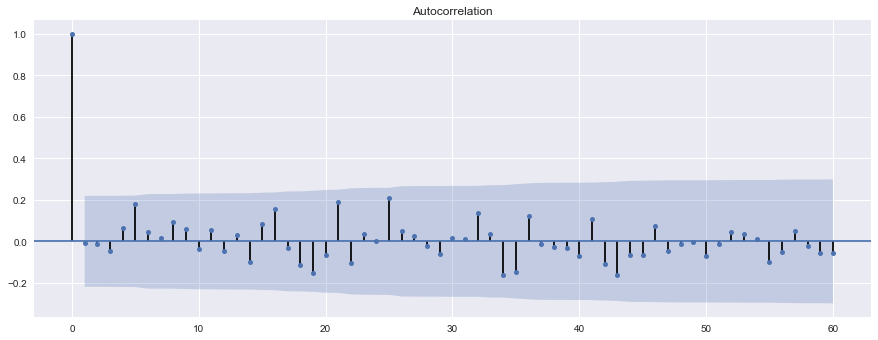

In [167]:
import statsmodels.api as sm

fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train, lags=60, ax=ax)
plt.show()

Видим, что в качестве начального приближения для $q$ можно взять $q = 1$ <br>
Теперь построим график частичной автокорелляции

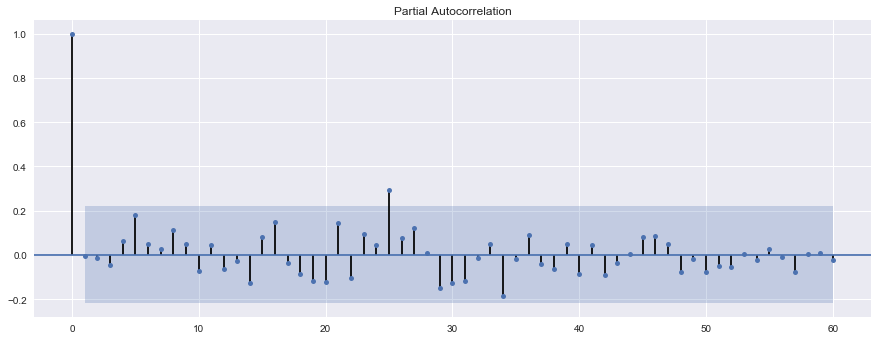

In [168]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(train, lags=60, ax=ax)
plt.show()

Видим, что в качестве начального приближения для $p$ можно взять $p = 1$

Произведем подбор параметров

In [253]:
import itertools
from statsmodels.tsa.arima_model import ARIMA, ARMAResults 
import warnings
warnings.filterwarnings("ignore")

q = range(2)
p = range(2)
d = [0]

pdq = list(itertools.product(p, d, q))
best_aic = 1e15
best_params = []

for param in pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(train, order=param, 
                                              enforce_stationarity=False, enforce_invertibility=False)
        model = model.fit()
        print('ARIMA{} – AIC:{}'.format(param, model.aic))
        if(model.aic < best_aic):
            best_aic = model.aic
            best_params = [param]
    except:
        pass




ARIMA(0, 0, 1) – AIC:-218.0657609568428
ARIMA(1, 0, 0) – AIC:-221.76795980820117
ARIMA(1, 0, 1) – AIC:-215.81754670205166


In [266]:
best_params

[(1, 0, 0)]

Предсказываем

In [267]:
model = sm.tsa.statespace.SARIMAX(train, order=best_params[0], 
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()
predictions = model.get_forecast(steps=20)
pred_ci = predictions.conf_int()

Посмотрим на предсказания 

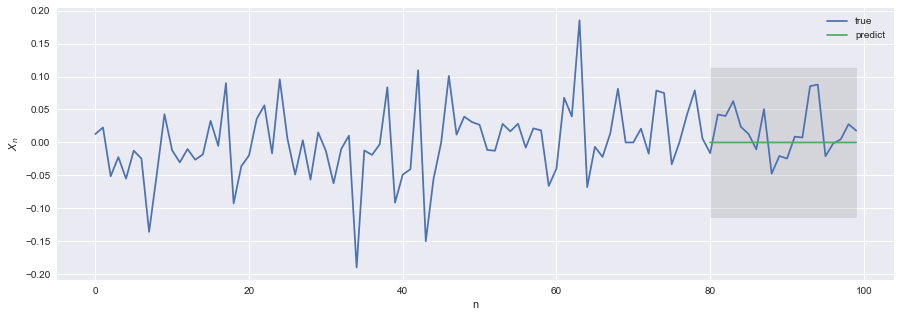

In [268]:
plt.figure(figsize=(15, 5))
plt.plot(data, label='true')
plt.plot(np.arange(len(train), len(train) + 20), predictions.predicted_mean, label='predict')
plt.fill_between(pred_ci.index + len(train), 
                 pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='gray', alpha=.2)
plt.xlabel('n')
plt.ylabel('$X_n$')
plt.legend()
plt.show()

Хм, константа(  <br>
Возможно это лучшее, что может предсказать модель <br>
Посмотрим на mse

In [259]:
mse = ((predictions.predicted_mean - test) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(mse))

Среднеквадратичная ошибка: 0.0015455417047019707


Попробуем взять другие параметры, чтобы не получалась константа

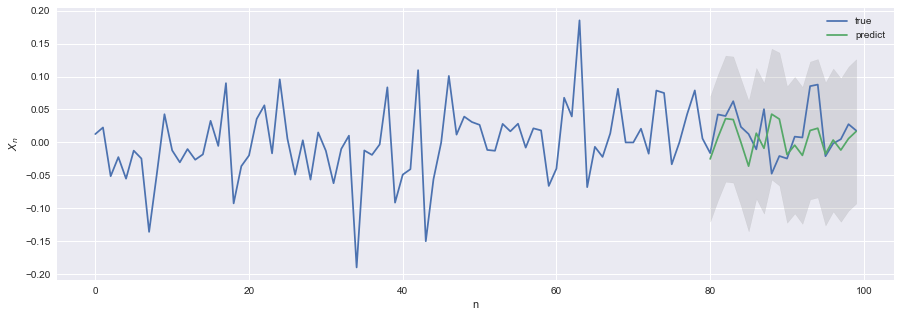

In [269]:
model = sm.tsa.statespace.SARIMAX(train, order=(8, 0, 15), 
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()
predictions = model.get_forecast(steps=20)
pred_ci = predictions.conf_int()
plt.figure(figsize=(15, 5))
plt.plot(data, label='true')
plt.plot(np.arange(len(train), len(train) + 20), predictions.predicted_mean, label='predict')
plt.fill_between(pred_ci.index + len(train), 
                 pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='gray', alpha=.2)
plt.xlabel('n')
plt.ylabel('$X_n$')
plt.legend()
plt.show()

In [270]:
mse = ((predictions.predicted_mean - test) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(mse))

Среднеквадратичная ошибка: 0.0015535428370276447


Видим, что несмотря на то, что визуально предсказание кажется лучше, mse оказался больше, чем у модели, предсказывающей константу. Видимо константа действительно самый оптимальный вариант в рамках данной модели.

## Задача 3

In [374]:
data = pd.read_csv('hw12t3_train.csv')
data.head()

,Unnamed: 0,y
0,0,2.186541
1,1,4.112926
2,2,2.342754
3,3,0.886390
4,4,1.538709


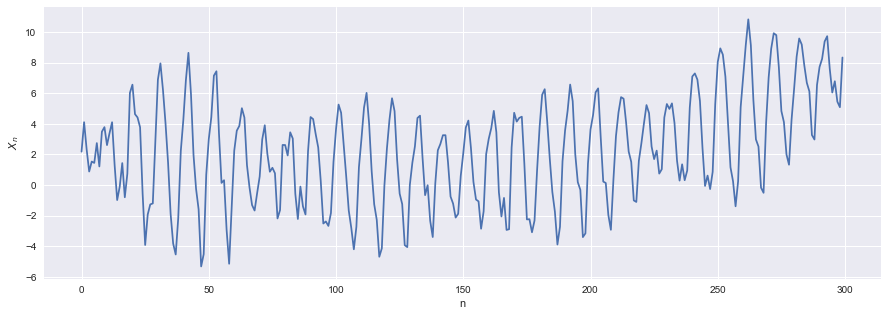

In [375]:
data = np.array(data.y)
plt.figure(figsize=(15, 5))
plt.plot(data)
plt.xlabel('n')
plt.ylabel('$X_n$')
plt.show()

Видим, что есть небольшой тренд и сезонность длины 10. Кроме того, видим большое различие в дисперсии

Разделим на обучение и тест

In [376]:
train = data[:-40]
test = data[-40:]

Сначала применим ARIMA <br>
Для этого нужно сначала стабилизировать ряд. убрать тренд и сезонность. Для начала для стабилизации дисперсии применим преобразование Бокса-Кокса, после чего применим сезонное дифференцирование

(Также прибавим 10 к временному ряду, чтобы можно было применить преобразование Бокса-Кокса)

In [377]:
# преобразование Бокса-Кокса
train_boxcox, lambd = sps.boxcox(train + 10)
# сезонное дифференцирование
train_stat = train_boxcox[10:] - train_boxcox[:-10]
train_stat = train_stat[10:] - train_stat[:-10]

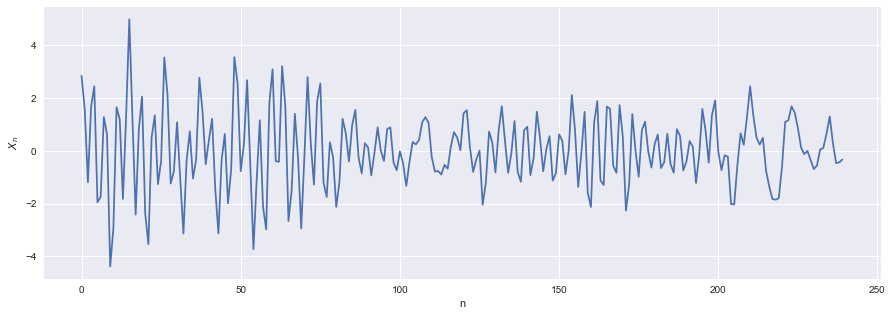

In [378]:

plt.figure(figsize=(15, 5))
plt.plot(train_stat)
plt.xlabel('n')
plt.ylabel('$X_n$')
plt.show()

In [379]:
kpss(train_stat)

(0.038317578978208304,
 0.1,
 15,
 {'1%': 0.739, '10%': 0.347, '2.5%': 0.574, '5%': 0.463})

Гипотеза о стационароности ряда не отвергается

Построим графики ACF и PACF для полученного ряда

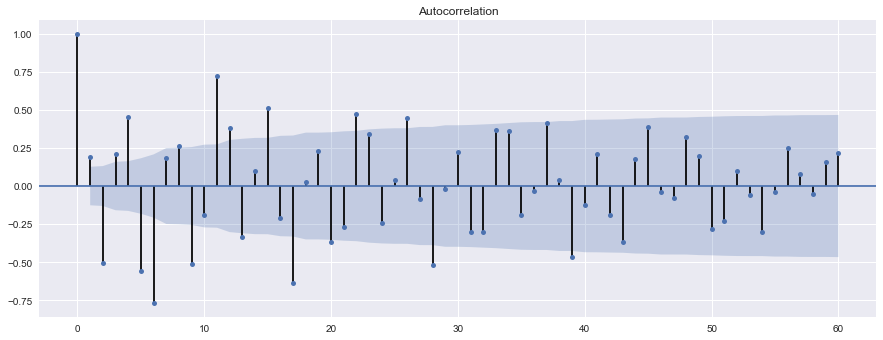

In [302]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_stat, lags=60, ax=ax)
plt.show()

В качестве начального приближения возьмем $q = 15$

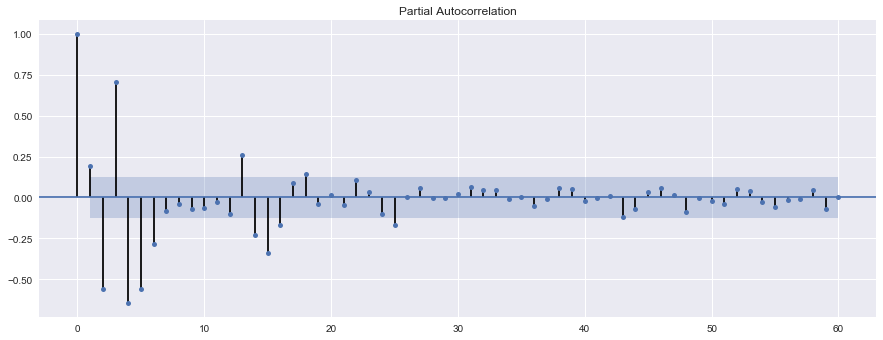

In [304]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(train_stat, lags=60, ax=ax)
plt.show()

В качестве начального приближения возьмем $p = 15$

In [305]:
import itertools
from statsmodels.tsa.arima_model import ARIMA, ARMAResults 
import warnings
warnings.filterwarnings("ignore")

q = range(15)
p = range(15)
d = [2]

pdq = list(itertools.product(p, d, q))
best_aic = 1e15
best_params = []

for param in pdq:
    try:
        model = sm.tsa.statespace.SARIMAX(train_stat, order=param,
                                              enforce_stationarity=False, enforce_invertibility=False)
        model = model.fit()
        print('ARIMA{} – AIC:{}'.format(param, model.aic))
        if(model.aic < best_aic):
            best_aic = model.aic
            best_params = [param]
    except:
        pass





ARIMA(0, 2, 1) – AIC:948.5532012238496
ARIMA(0, 2, 2) – AIC:867.4472719319413
ARIMA(0, 2, 3) – AIC:697.352340985912
ARIMA(0, 2, 4) – AIC:691.7360143625581
ARIMA(0, 2, 5) – AIC:655.5136423410765
ARIMA(0, 2, 6) – AIC:627.2937607046719
ARIMA(0, 2, 7) – AIC:500.9206323834978
ARIMA(0, 2, 8) – AIC:442.65332695024017
ARIMA(0, 2, 9) – AIC:535.517332163731
ARIMA(0, 2, 10) – AIC:432.21429906213586
ARIMA(0, 2, 11) – AIC:442.8148163265446
ARIMA(0, 2, 12) – AIC:406.40973167021764
ARIMA(0, 2, 13) – AIC:358.30670845207214
ARIMA(0, 2, 14) – AIC:355.84032463406345
ARIMA(1, 2, 0) – AIC:1127.8155726153802
ARIMA(1, 2, 1) – AIC:950.5343485802892
ARIMA(1, 2, 2) – AIC:851.2040037906512
ARIMA(1, 2, 3) – AIC:698.3499424811748
ARIMA(1, 2, 4) – AIC:667.3705797039408
ARIMA(1, 2, 5) – AIC:655.819374142751
ARIMA(1, 2, 6) – AIC:594.7133912872303
ARIMA(1, 2, 7) – AIC:499.71001336170076
ARIMA(1, 2, 8) – AIC:454.5010568038291
ARIMA(1, 2, 9) – AIC:530.2835624383736
ARIMA(1, 2, 10) – AIC:424.67272489832885
ARIMA(1, 2, 11

ARIMA(13, 2, 11) – AIC:127.05985787242612
ARIMA(13, 2, 12) – AIC:99.74446359047005
ARIMA(13, 2, 13) – AIC:98.14425063930224
ARIMA(13, 2, 14) – AIC:93.03517228942088
ARIMA(14, 2, 0) – AIC:256.335117330717
ARIMA(14, 2, 1) – AIC:257.84999467559646
ARIMA(14, 2, 2) – AIC:230.17572629447272
ARIMA(14, 2, 3) – AIC:239.1914732768925
ARIMA(14, 2, 4) – AIC:212.01240234942333
ARIMA(14, 2, 5) – AIC:198.83949697987373
ARIMA(14, 2, 6) – AIC:197.39589566444158
ARIMA(14, 2, 7) – AIC:nan
ARIMA(14, 2, 8) – AIC:1301.4872228602658
ARIMA(14, 2, 9) – AIC:419.1930680110937
ARIMA(14, 2, 10) – AIC:139.51664326152138
ARIMA(14, 2, 11) – AIC:106.23096140274312
ARIMA(14, 2, 12) – AIC:99.10546358409265
ARIMA(14, 2, 13) – AIC:101.45977838243097
ARIMA(14, 2, 14) – AIC:92.46714085709995


In [306]:
best_params

[(14, 2, 14)]

Предскажем

In [380]:
model = sm.tsa.statespace.SARIMAX(train_stat, order=best_params[0], 
                                  enforce_stationarity=False, enforce_invertibility=False)
model = model.fit()
predictions = model.get_forecast(steps=40)
pred_ci = predictions.conf_int()

Посмотрим на предсказания стационарного ряда

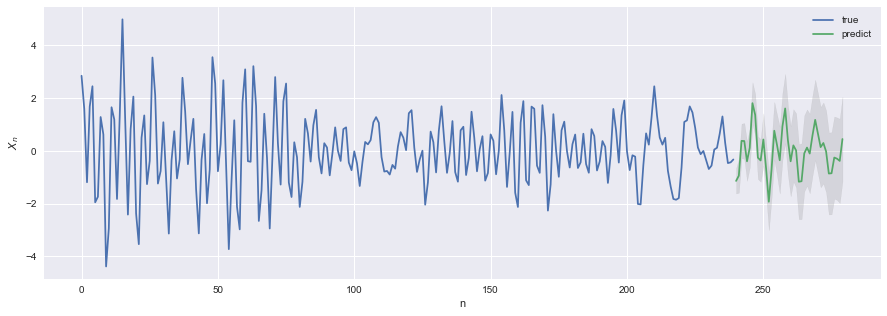

In [381]:
plt.figure(figsize=(15, 5))
plt.plot(train_stat, label='true')
plt.plot(np.arange(len(train_stat), len(train_stat) + 40), predictions.predicted_mean, label='predict')
plt.fill_between(pred_ci.index + len(train_stat), 
                 pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='gray', alpha=.2)
plt.xlabel('n')
plt.ylabel('$X_n$')
plt.legend()
plt.show()

Посмотрим на предсказания исходного ряда. Для этого проделаем обратные преобразования

In [382]:
#функция, производящая обратное преобразование к преобразованию Бокса-Кокса
def boxcox_inverted(data_boxcox, lambd):
    print(lambd)
    return (lambd * data_boxcox + 1) ** (1 / lambd)

prediction = []
stat_prediction = predictions.predicted_mean
for i in range(10):
    new_pred = stat_prediction[i] + train_boxcox[-10 + i]
    prediction.append(new_pred)
    
for i in range(10, 40):
    new_pred = stat_prediction[i] + prediction[i-10]
    prediction.append(new_pred)

0.9213140464597349


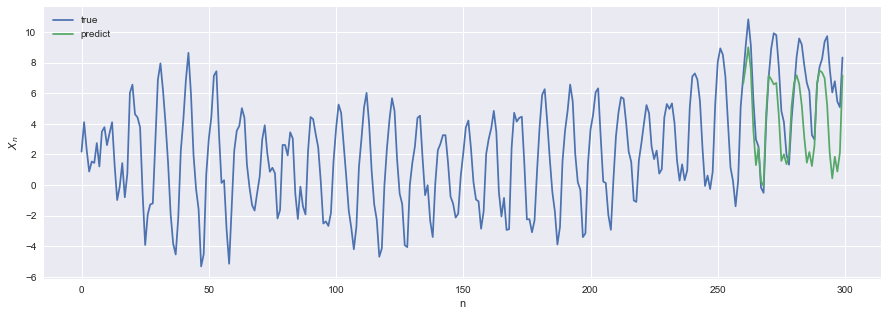

In [384]:
new_pred = boxcox_inverted(np.array(prediction), lambd=lambd) - 10
plt.figure(figsize=(15, 5))
plt.plot(data, label='true')
plt.plot(np.arange(len(train), len(train) + 40), new_pred, label='predict')
plt.xlabel('n')
plt.ylabel('$X_n$')
plt.legend()
plt.show()

In [385]:
mse = ((new_pred - test) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(mse))

Среднеквадратичная ошибка: 7.678910429776019


Посчитаем U-коэффициент Тейла

In [386]:
def U_coef(true, pred, X_n):
    coef = np.sqrt(np.sum((pred - true)**2)) / np.sqrt(np.sum((true - X_n)**2))
    return coef

In [388]:
U_coef(test, new_pred, train[-1])

0.8927894700764878

Теперь применим экспоненциальное сглаживание

In [362]:
# нужные файлики прикреплены к письму
from holtwinters import ExponentialSmoothing

In [391]:
model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=10)
model = model.fit()
predictions = model.forecast(40)

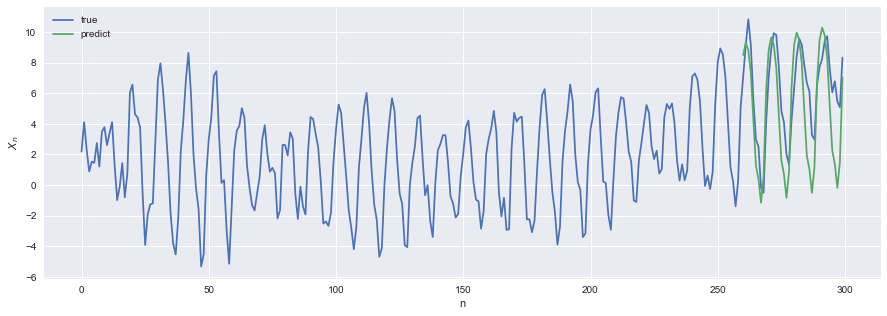

In [393]:
plt.figure(figsize=(15, 5))
plt.plot(data, label='true')
plt.plot(np.arange(len(train), len(train) + 40), predictions, label='predict')
plt.xlabel('n')
plt.ylabel('$X_n$')
plt.legend()
plt.show()

In [395]:
mse = ((predictions - test) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(mse))

Среднеквадратичная ошибка: 6.740964210191751


In [394]:
U_coef(test, predictions, train[-1])

0.8364890671566643

Как видим, среднеквадратичная ошибка и U-коэффициент Тейла уменьшились по сравнению с ARIMA 

## задача 4

In [397]:
data_4 = pd.read_excel('hw12t4_train.xlsx')
data_4.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,0.788794


Посмотрим на зависимости

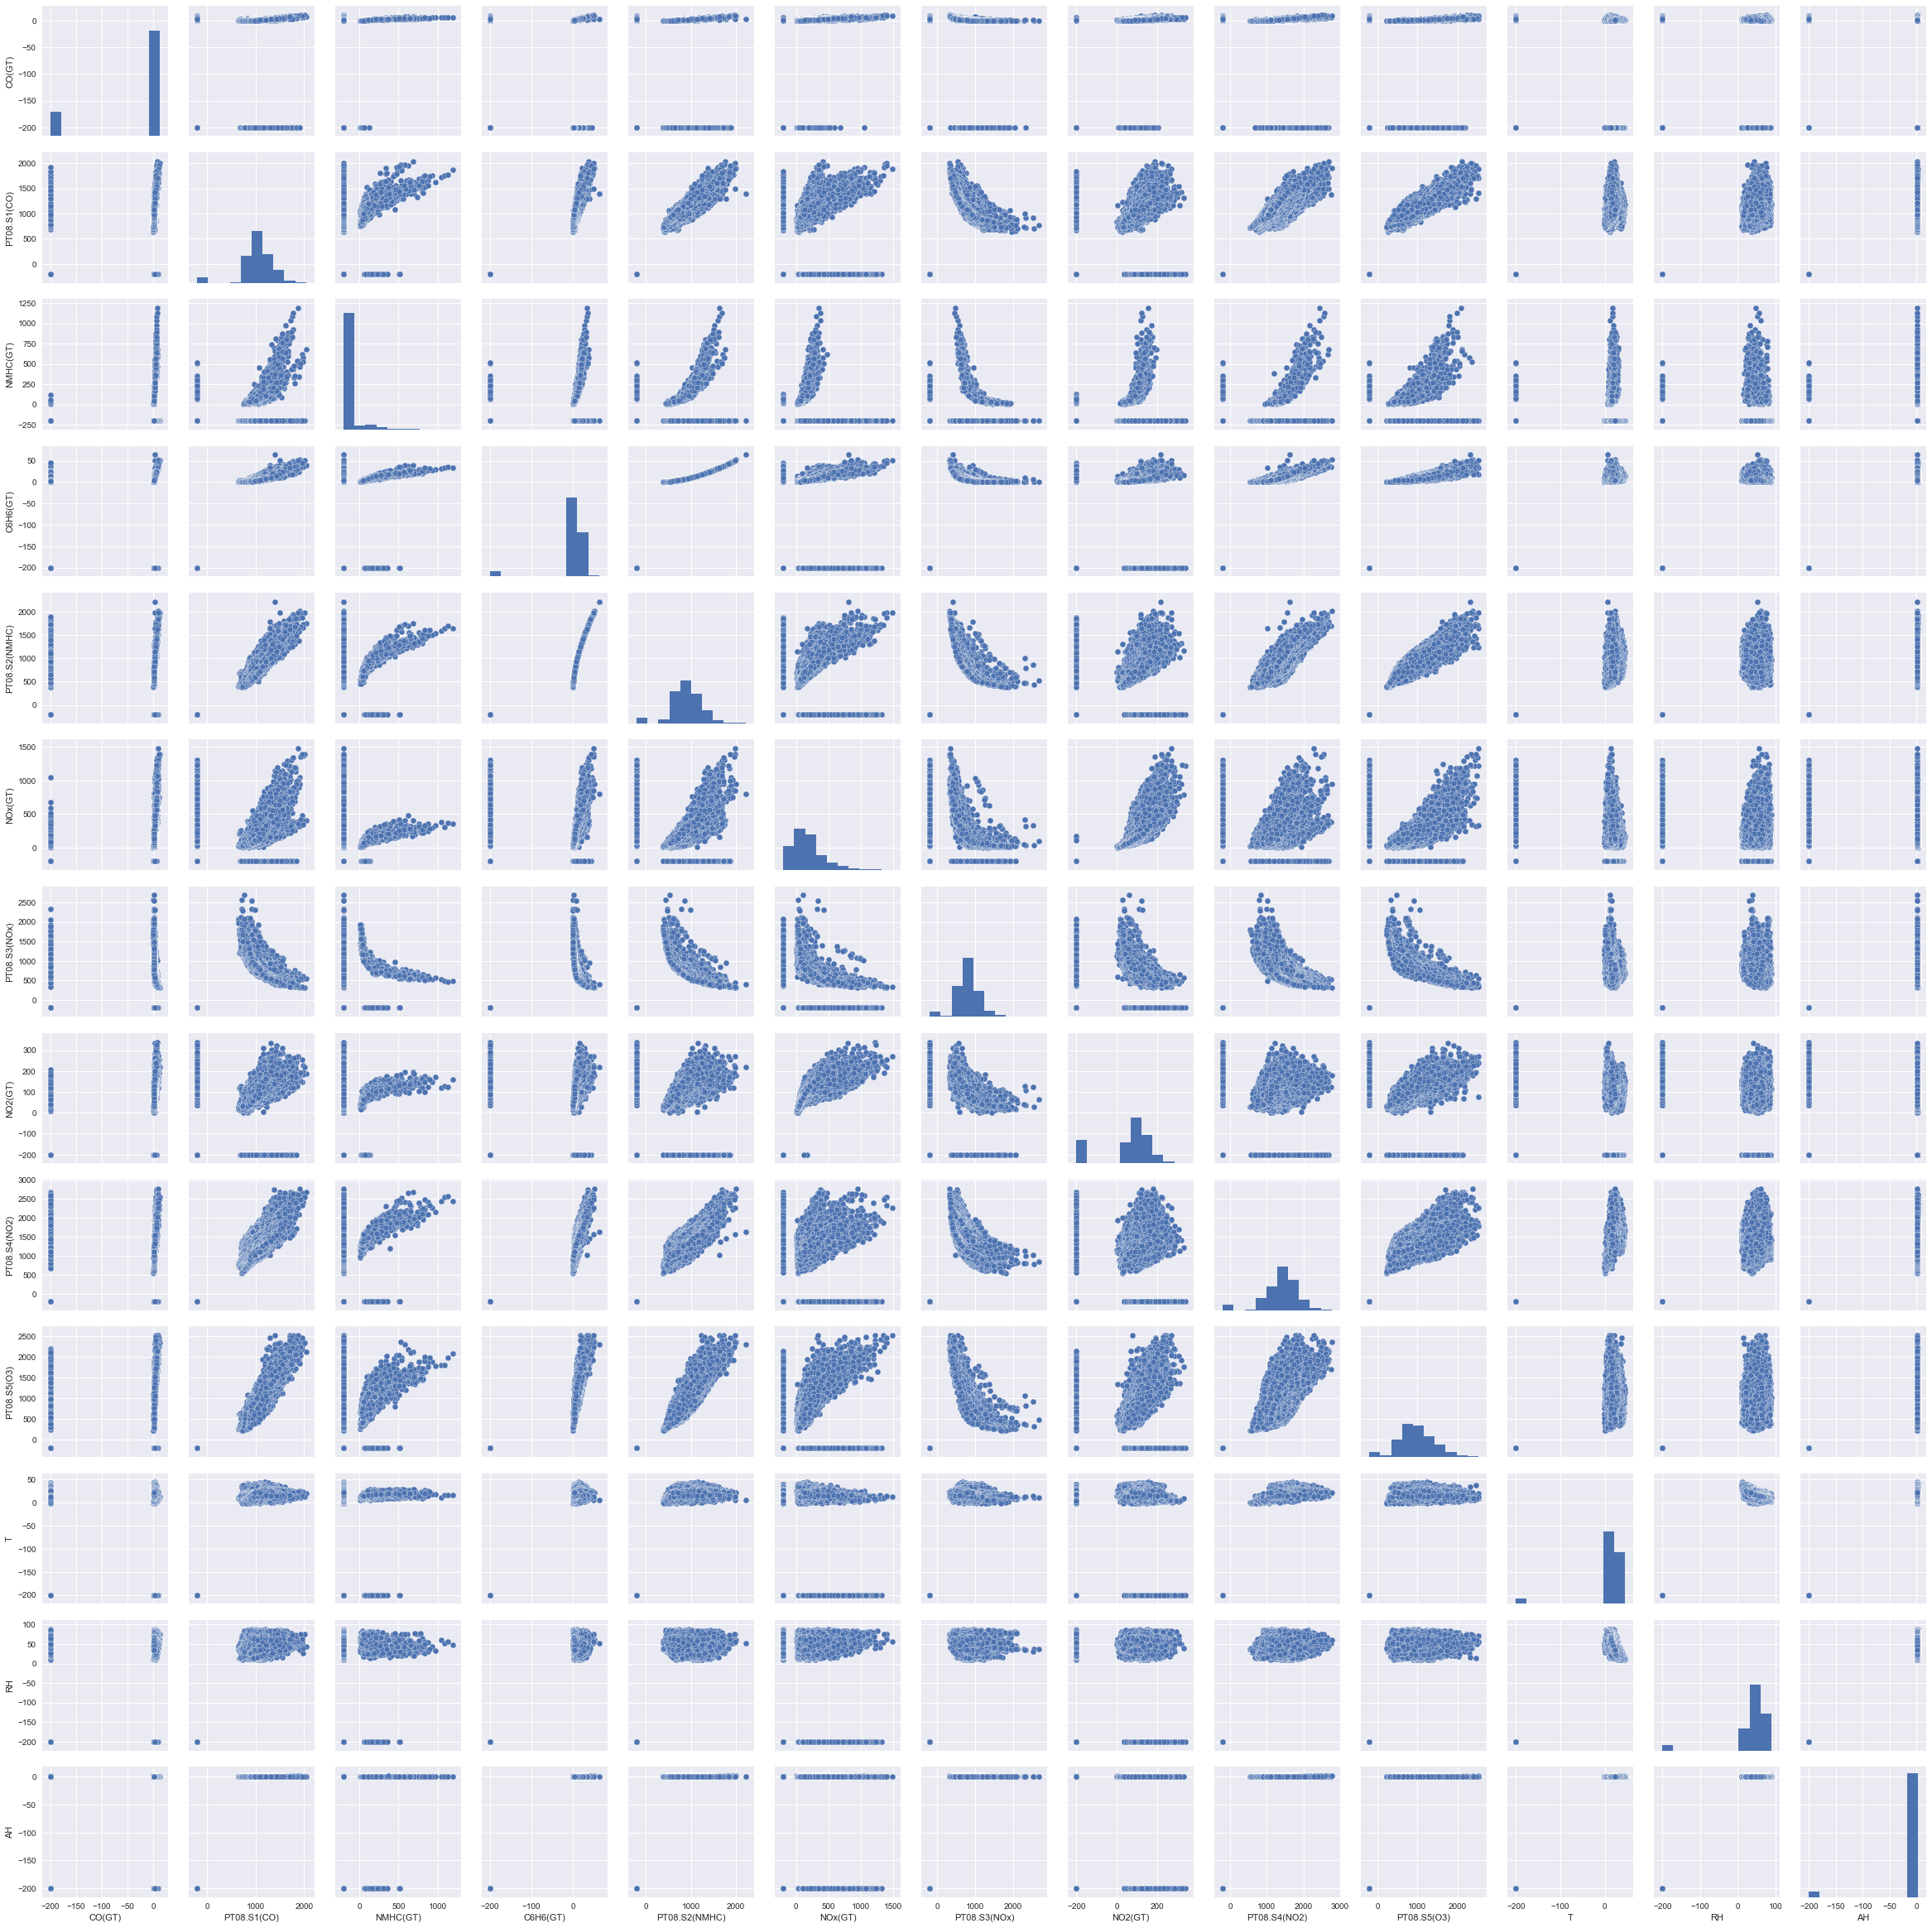

In [398]:
sns.pairplot(data_4)

Посмотрим на исходный ряд

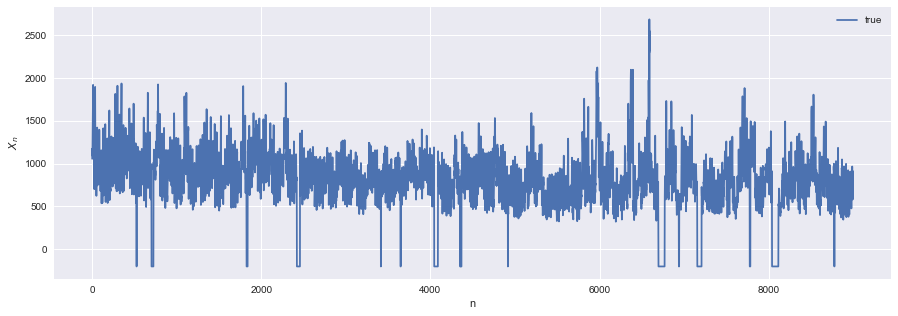

In [399]:
plt.figure(figsize=(15, 5))
plt.plot(data_4['PT08.S3(NOx)'], label='true')
plt.xlabel('n')
plt.ylabel('$X_n$')
plt.legend()
plt.show()

Из задания не совсем понятно, что от нас хотят. Возможно имелось ввиду, то что мы должны пресказать тестовые признаки регрессионной моделью и потом предсказанное использовать как экзогенные факторы для предсказания ряда, возможно то, что мы должны сначала предсказать ряд регрессионной моделью, а потом с помощью ARIMA предсказать остаток ряда. 

Я решила пойти, как мне кажется наиболее логичным путем: предсказывать ряд при условии фиксированных заранее известных других временных рядов (признаков). 

Делим на обучение и тест

In [475]:
y_train = data_4.iloc[:-300]['PT08.S3(NOx)']
y_test = data_4.iloc[-300:]['PT08.S3(NOx)']
columns = ['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)','PT08.S2(NMHC)',
           'NOx(GT)', 'NO2(GT)', 'PT08.S4(NO2)','PT08.S5(O3)', 'T', 'RH', 'AH']
features_train = np.array(data_4.iloc[:-300][columns])
features_test = np.array(data_4.iloc[-300:][columns])

Возьмем пока все признаки в качестве экзогенных факторов

In [476]:
features_train = np.array(features_train[:,2:], dtype=float)
features_test = np.array(features_test[:,2:], dtype=float)

model = sm.tsa.statespace.SARIMAX(np.array(y_train), exog=features_train, 
                                  order=(2, 1, 1), 
                                  enforce_stationarity=False, enforce_invertibility=False)

In [477]:
model = model.fit()
predictions = model.get_forecast(steps=300, exog=features_test)
pred_ci = predictions.conf_int()

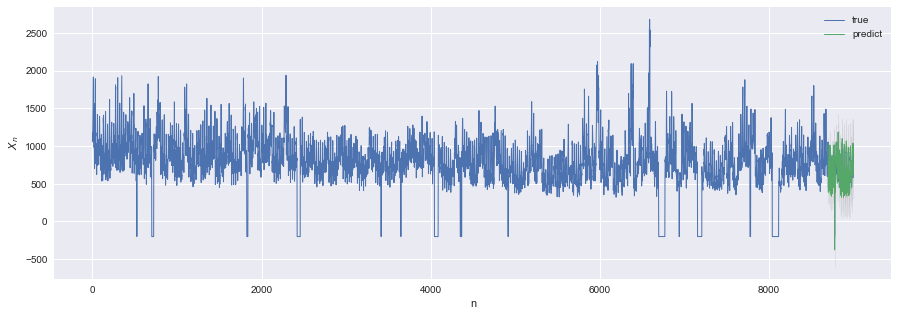

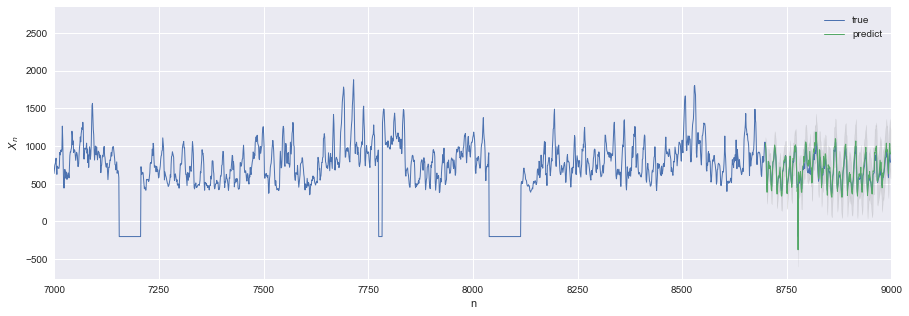

In [478]:
plt.figure(figsize=(15, 5))
plt.plot(np.hstack((y_train, y_test)), label='true', lw=1)
plt.plot(np.arange(len(y_train), len(y_train) + 300), predictions.predicted_mean, label='predict', lw=1)
plt.fill_between(pred_ci.index + len(y_train), 
                 pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='gray', alpha=.2)
plt.xlabel('n')
plt.ylabel('$X_n$')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(np.hstack((y_train, y_test)), label='true', lw=1)
plt.plot(np.arange(len(y_train), len(y_train) + 300), predictions.predicted_mean, label='predict', lw=1)
plt.fill_between(pred_ci.index + len(y_train), 
                 pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='gray', alpha=.2)
plt.xlabel('n')
plt.ylabel('$X_n$')
plt.xlim(7000, 9000)
plt.legend()
plt.show()

In [479]:
mse = ((predictions.predicted_mean - y_test) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(mse))

Среднеквадратичная ошибка: 3402.4535528496995


Получилось довольно неплохо. Попробуем подобрать признаки. Для этого посмотрим на них и попробуем понять какие признаки влияют больше всего

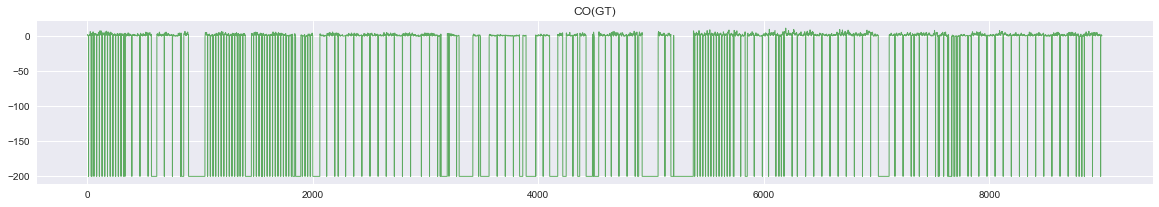

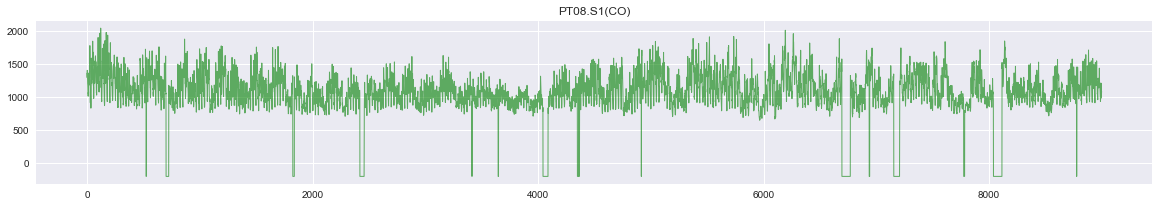

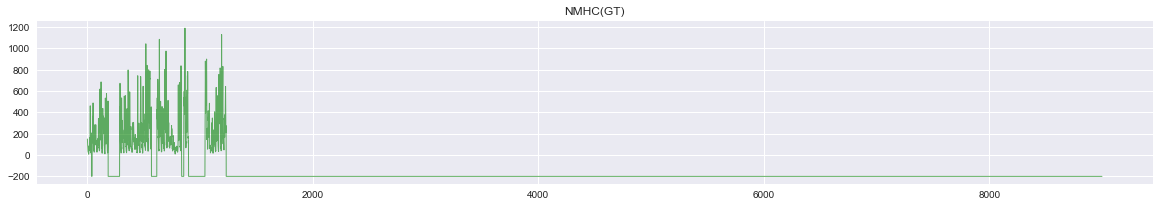

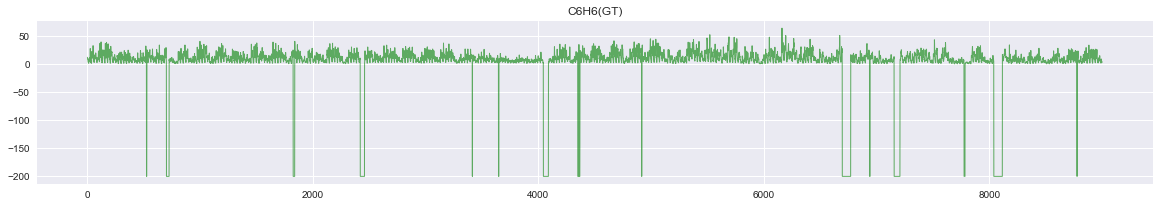

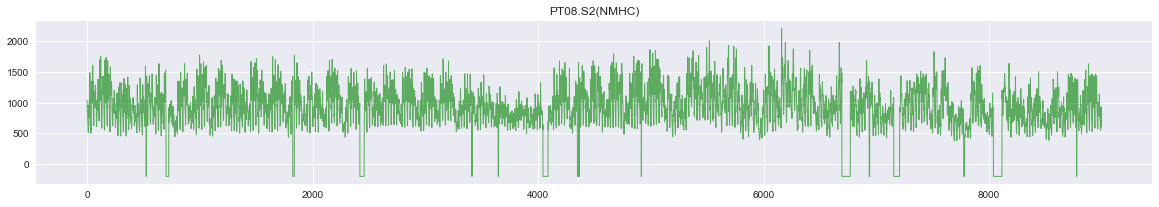

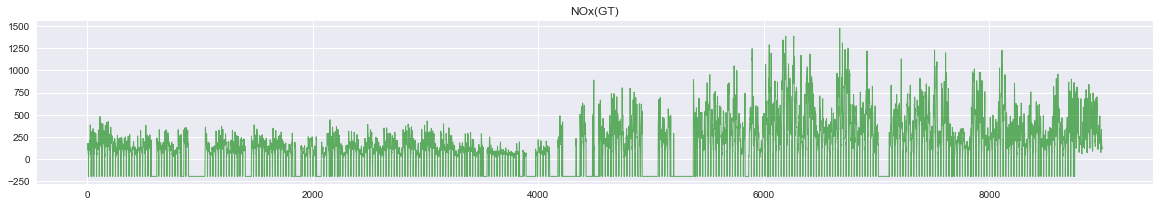

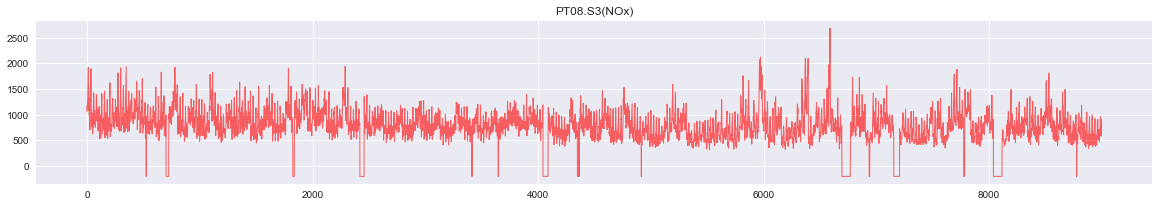

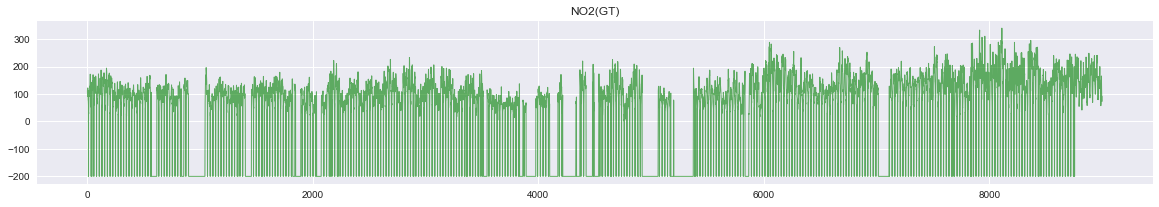

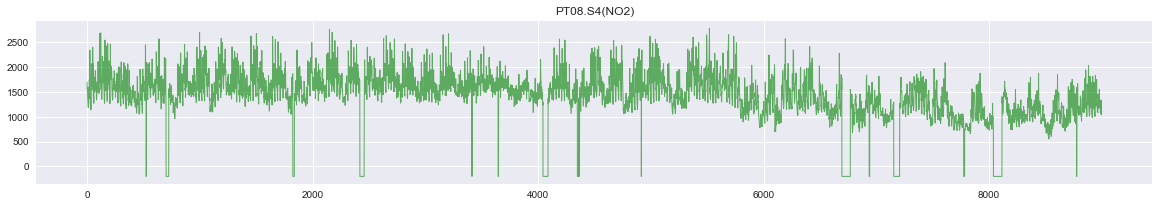

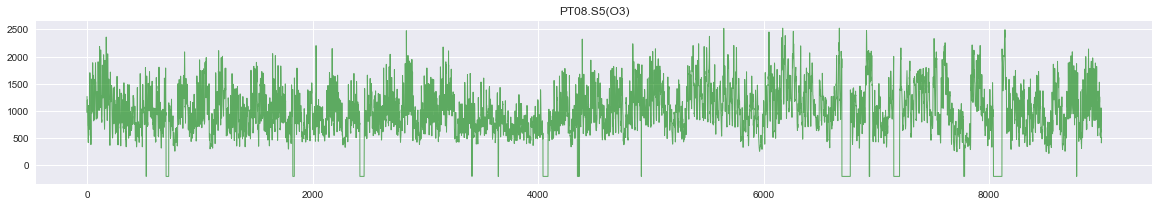

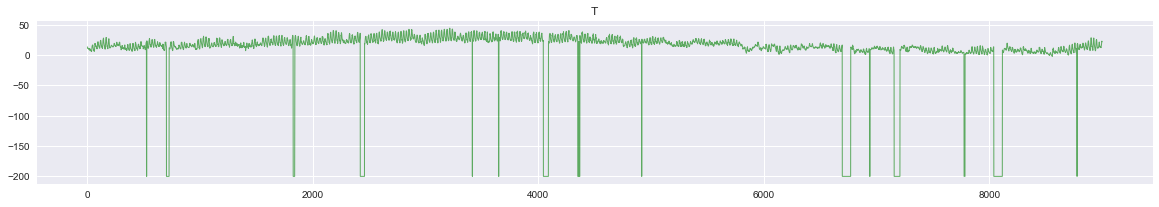

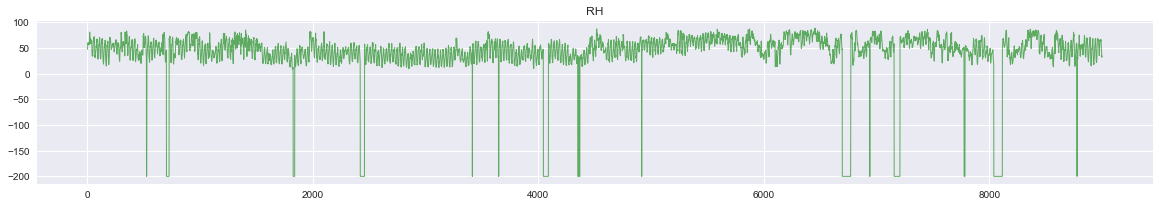

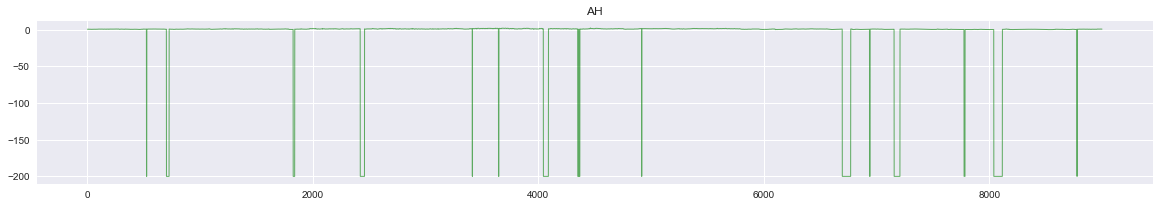

In [449]:
for column in data_4.columns[2:]:
    plt.figure(figsize=(20, 3))
    color = 'green'
    if column == 'PT08.S3(NOx)':
        color = 'red'
    plt.plot(data_4[column], color=color, lw=1, alpha=0.6)
    plt.title(column)
    plt.show()

Остюда можно понять, что можно выкинуть первый признак, последний и третий (он почти на всем трейне и на всем тесте константа), они кажутся совсем не информативными. Также неинформативным кажется четвертый признак -C6H6(GT). По оставшимся признакам произведем перебор в поисках наименьшего aic

In [501]:
i1 = [0, 1]
i4 = [0, 1]
i5 = [0, 1]
i7 = [0, 1]
i8 = [0, 1]
i9 = [0, 1]
i10 = [0, 1]
i11 = [0, 1]

con_ind = [1, 4, 5, 7, 8, 9, 10, 11]
params = list(itertools.product(i1, i4, i5, i7, i8, i9, i10, i11))
best_aic = 1e15
best_params = None

for param in params[1:]:
    exogenous_regressors = features_train[:,con_ind][:,np.where(param)[0]]
    try:
        model = sm.tsa.statespace.SARIMAX(np.array(y_train), exog=exogenous_regressors, 
                                          order=(2, 1, 1), 
                                          enforce_stationarity=False, 
                                          enforce_invertibility=False)
        model = model.fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_params = param
    except:
        pass

In [503]:
best_params

(1, 1, 0, 1, 1, 1, 1, 1)

Предсказываем

In [504]:
exogenous_regressors_train = features_train[:,con_ind][:,np.where(best_params)[0]]
exogenous_regressors_test = features_test[:,con_ind][:,np.where(best_params)[0]]

model = sm.tsa.statespace.SARIMAX(np.array(y_train), exog=exogenous_regressors_train, 
                                  order=(2, 1, 1), 
                                  enforce_stationarity=False, enforce_invertibility=False)

model = model.fit()
predictions = model.get_forecast(steps=300, exog=exogenous_regressors_test)
pred_ci = predictions.conf_int()

И смотрим, что получилось

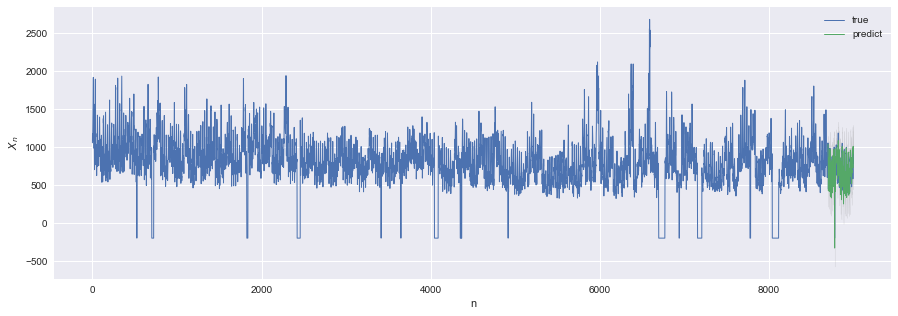

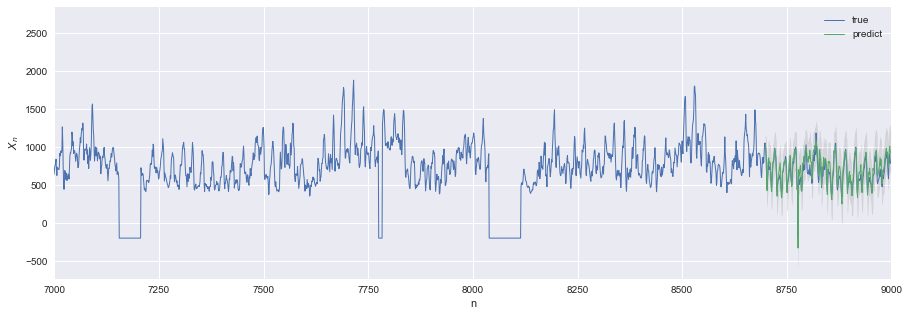

In [505]:
plt.figure(figsize=(15, 5))
plt.plot(np.hstack((y_train, y_test)), label='true', lw=1)
plt.plot(np.arange(len(y_train), len(y_train) + 300), predictions.predicted_mean, label='predict', lw=1)
plt.fill_between(pred_ci.index + len(y_train), 
                 pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='gray', alpha=.2)
plt.xlabel('n')
plt.ylabel('$X_n$')
plt.legend()
plt.show()

plt.figure(figsize=(15, 5))
plt.plot(np.hstack((y_train, y_test)), label='true', lw=1)
plt.plot(np.arange(len(y_train), len(y_train) + 300), predictions.predicted_mean, label='predict', lw=1)
plt.fill_between(pred_ci.index + len(y_train), 
                 pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='gray', alpha=.2)
plt.xlabel('n')
plt.ylabel('$X_n$')
plt.xlim(7000, 9000)
plt.legend()
plt.show()

In [506]:
mse = ((predictions.predicted_mean - y_test) ** 2).mean()
print('Среднеквадратичная ошибка: {}'.format(mse))

Среднеквадратичная ошибка: 6670.836360520466


Кажется, что предсказание не стало сильно лучше( <br>
Но в любом случае, оно получилось довольно хорошим

## Задача 5

AR(1):

$$X_t = \alpha X_{t - 1} + \epsilon_t$$
$$\Rightarrow e^{-1} = cov(X_t, X_{t - 1}) = \alpha cov(X_{t - 1}, X_{t - 1}) + 0 = \alpha e^0 \; \Rightarrow \alpha = e^{-1}$$

AR(2):

$$X_t = \alpha X_{t - 1} + \beta X_{t - 1} + \epsilon_t$$
Аналогично
$$e^{-1} = \alpha + \beta e^{-1}$$
$$e^{-2} = \alpha e^{-1} + \beta$$
Отсюда $\beta = 0$, $\alpha = e^{-1} \Rightarrow AR(1)$

In [502]:
def simulating(steps, grid):
    sample = [0]
    alpha = np.exp(-grid)
    for i in range(steps - 1):
        eps = sps.norm(loc=0, scale=0.1).rvs()
        sample.append(alpha * sample[-1] + eps)
    return np.array(sample)

Моделируем

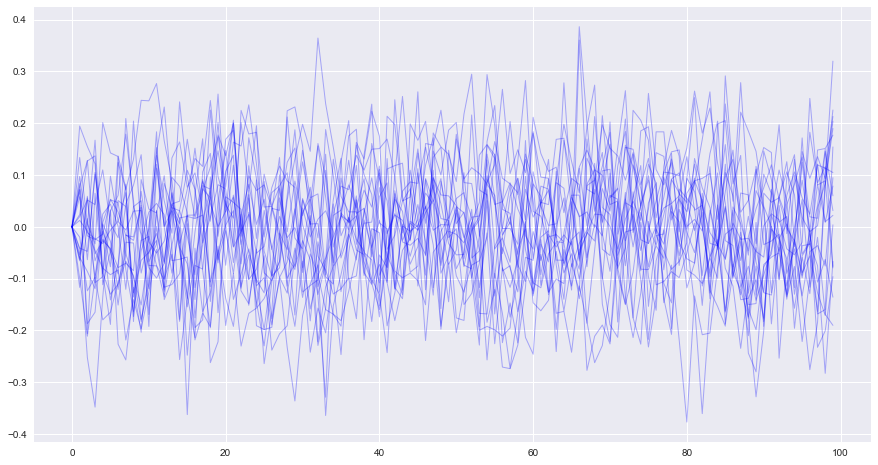

In [509]:
plt.figure(figsize=(15, 8))
for i in range(20):
    plt.plot(simulating(100, 1), lw=1, alpha=0.3, color='blue')

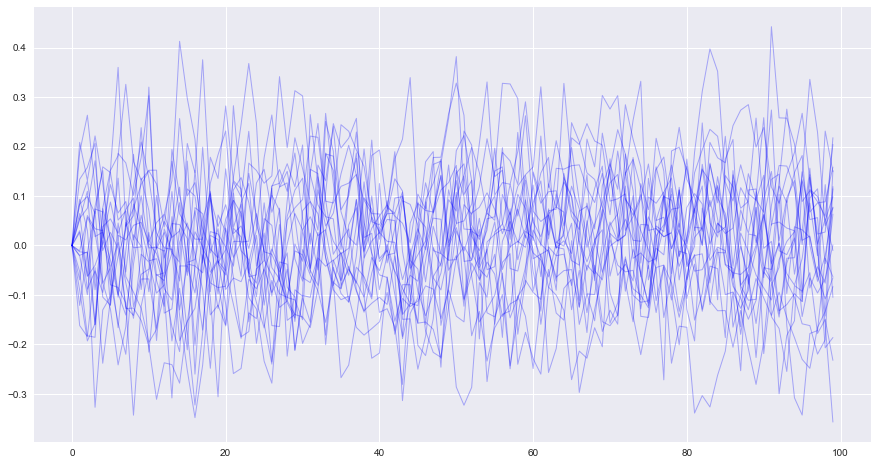

In [531]:
plt.figure(figsize=(15, 8))
for i in range(20):
    plt.plot(simulating(100, 0.5), lw=1, alpha=0.3, color='blue')

Оценим ковариационную функцию процесса

In [510]:
def R(sample):
    Rs = []
    N = len(sample)
    for m in range(N):
        Rs.append(np.sum(sample[:N - m] * sample[-N + m:]) / (N - m))
    return Rs

Посмотрим на зависимость близости нашей оценки к истинной от величины шага при моделировании

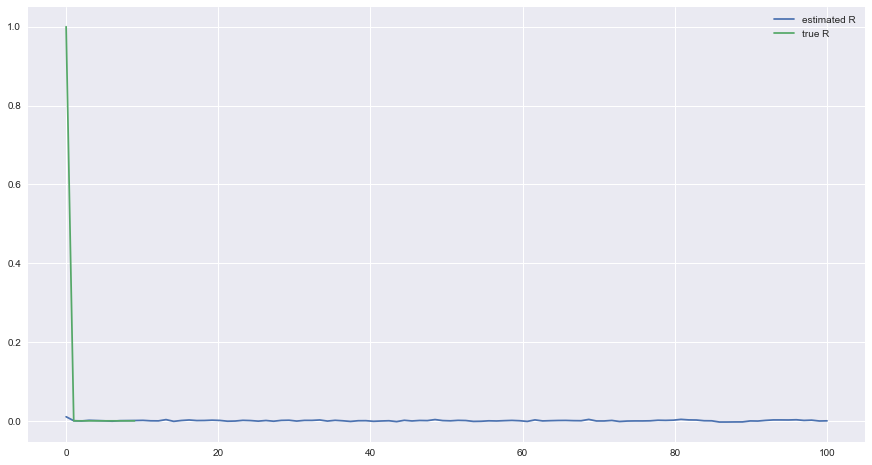

In [546]:
N = 100
grid = 10
sample = simulating(N, grid)
plt.figure(figsize=(15, 8))
plt.plot(np.linspace(0, N, N), R(sample), label='estimated R')
plt.plot(np.exp(- np.arange(0, N, grid)), label='true R')
plt.legend()
plt.show()

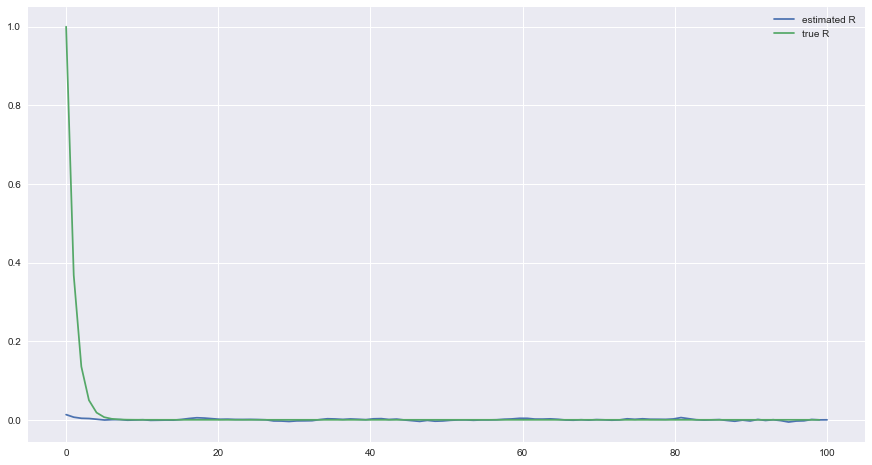

In [530]:
N = 100
grid = 1
sample = simulating(N, grid)

plt.figure(figsize=(15, 8))
plt.plot(np.linspace(0, N, N), R(sample), label='estimated R')
plt.plot(np.exp(- np.arange(0, N, grid)), label='true R')
plt.legend()
plt.show()

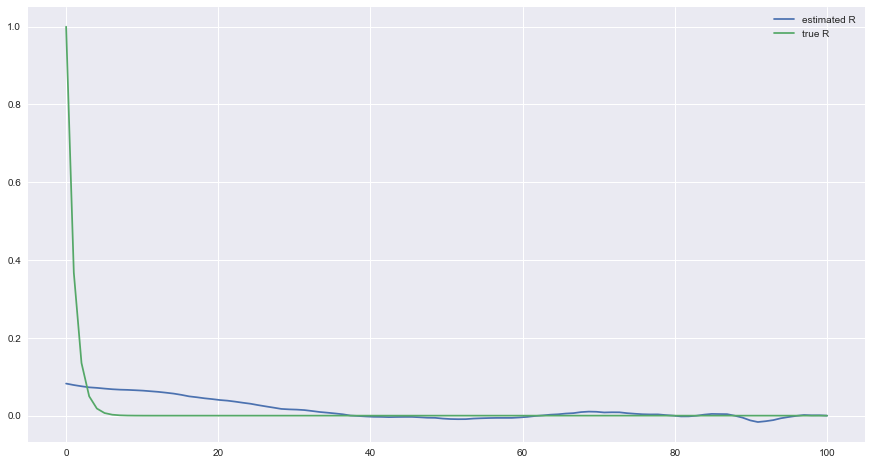

In [537]:
N = 100
grid = 0.1
sample = simulating(N, grid)

plt.figure(figsize=(15, 8))
plt.plot(np.linspace(0, N, N), R(sample), label='estimated R')
plt.plot(np.linspace(0, N, N), np.exp(- np.arange(0, N)), label='true R')
plt.legend()
plt.show()

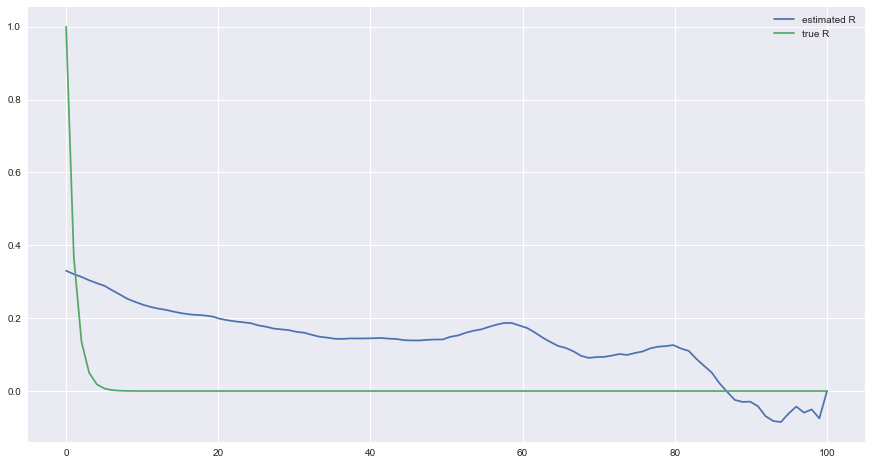

In [543]:
N = 100
grid = 0.001
sample = simulating(N, grid)

plt.figure(figsize=(15, 8))
plt.plot(np.linspace(0, N, N), R(sample), label='estimated R')
plt.plot(np.linspace(0, N, N), np.exp(- np.arange(0, N)), label='true R')
plt.legend()
plt.show()

При маленькой величине шага R(m) при маленьких m вычисляется более точно, а при величине шага побольше  R(m) при больших m вычисляется точнее.